In [2]:
import os
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [3]:

# Función para cargar los datos desde un archivo CSV y dividir en entrenamiento y prueba
def load_data(filename):
    data = pd.read_csv(filename)
    temperature = data['T (degC)'].values  # Tomar solo la columna de temperatura
    return temperature

# Cargar datos desde el archivo CSV
data = load_data("jena_climate_2009_2016.csv")

In [5]:
# Normalizar los datos (opcional pero generalmente recomendado)
mean = data.mean(axis=0)
std = data.std(axis=0)
data_normalized = (data - mean) / std

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(data_normalized, test_size=0.2)

In [7]:
train_data

array([-0.98752229, -0.4319453 ,  0.7314424 , ...,  0.69938988,
       -1.24869096, -0.32391644])

In [9]:
# Darle la forma correcta a los datos
x_train = train_data.reshape((train_data.shape[0], 1, 1))
x_test = test_data.reshape((test_data.shape[0], 1, 1))

# Definir el número de clases (en este caso, es solo una regresión)
n_classes = 1

In [10]:
# Función para construir el modelo de transformador
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention y Normalización
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Parte Feed Forward
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [11]:
# Función para construir el modelo de transformador
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention y Normalización
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Parte Feed Forward
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [12]:
# Función para construir el modelo
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes)(x)  # Una neurona de salida para la predicción de temperatura
    return keras.Model(inputs, outputs)

In [13]:
# Construir el modelo
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [15]:
model.compile(
    loss="mse",  # Usar MSE para regresión
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"],  # Métrica de error absoluto medio
)
model.summary()

# Entrenar el modelo
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train,
    x_train,  # Usamos x_train como target, ya que estamos tratando de predecir la temperatura
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
)

# Evaluar el modelo en datos de prueba
mse, mae = model.evaluate(x_test, x_test, verbose=1)  # Usamos x_test como target también
print("Mean Squared Error on Test Data:", mse)
print("Mean Absolute Error on Test Data:", mae)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1)      │      7,169 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 1)      │          2 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 4)      │          8 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 4)      │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1, 1)      │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 1)      │          2 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1)      │      7,169 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 1)      │          2 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1, 4)      │          8 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 4)      │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1, 1)      │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 1)      │          2 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 29,129 (113.79 KB)

 Trainable params: 29,129 (113.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 51s 10ms/step - loss: 0.0143 - mae: 0.0794 - val_loss: 2.3062e-04 - val_mae: 0.0111
Epoch 2/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.0144 - mae: 0.0792 - val_loss: 1.2729e-04 - val_mae: 0.0087
Epoch 3/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - loss: 0.0144 - mae: 0.0788 - val_loss: 3.8773e-04 - val_mae: 0.0166
Epoch 4/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - loss: 0.0143 - mae: 0.0782 - val_loss: 1.0321e-04 - val_mae: 0.0083
Epoch 5/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0142 - mae: 0.0777 - val_loss: 2.7288e-04 - val_mae: 0.0139
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.0445e-04 - mae: 0.0083
Mean Squared Error on Test Data: 0.0001043594311340712
Mean Absolute Error on Test Data: 0.008301449939608574


c:\Users\elian.rodriguez\tarea_otero\.venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10497/10512 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

c:\Users\elian.rodriguez\tarea_otero\.venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10512/10512 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


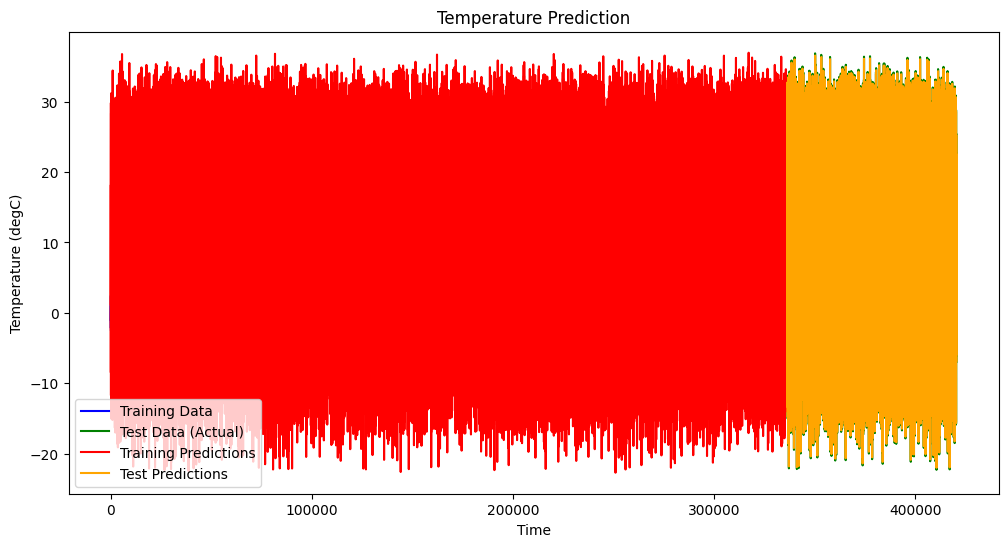

In [17]:
import matplotlib.pyplot as plt

# Predicciones del modelo en los datos de entrenamiento y prueba
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

# Deshacer la normalización de los datos
train_predictions = (train_predictions * std) + mean
test_predictions = (test_predictions * std) + mean

# Deshacer la normalización de los datos de prueba (inputs)
x_test_original = (x_test * std) + mean

# Graficar resultados
plt.figure(figsize=(12, 6))

# Graficar datos de entrenamiento
plt.plot(x_train.squeeze(), label='Training Data', color='blue')

# Graficar datos de prueba
plt.plot(range(len(x_train), len(x_train) + len(x_test)), x_test_original.squeeze(), label='Test Data (Actual)', color='green')

# Graficar predicciones en datos de entrenamiento
plt.plot(range(len(train_predictions)), train_predictions.squeeze(), label='Training Predictions', color='red')

# Graficar predicciones en datos de prueba
plt.plot(range(len(x_train), len(x_train) + len(test_predictions)), test_predictions.squeeze(), label='Test Predictions', color='orange')

plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()
